# PI Loop Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
import control as con

from rfproto import pi_filter, nco

## Overview 

A **Proportional + Integrator (PI) Loop Filter** is used in closed-loop control systems to track input offsets/errors (e.g. frequency or phase offsets in the case of Frequency Error Detectors (FED) or Phase Error Detectors (PEDs), respectively) and provide a corresponding output correction value to drive the loop/system to zero error. Other closed-loop examples using PI filters are Phase Locked Loops (PLLs) and Frequency Locked Loops (FLLs).

It's basic structure involves an error integrator (scaled by integral gain constant $K_{i}$) summed with a portion of the current error (scaled by proportional gain constant $K_{p}$). For example, when used in a phase correction loop (phase error detector (PED) and phase-rotating NCO), the structure looks like:

<div style="text-align:center;">
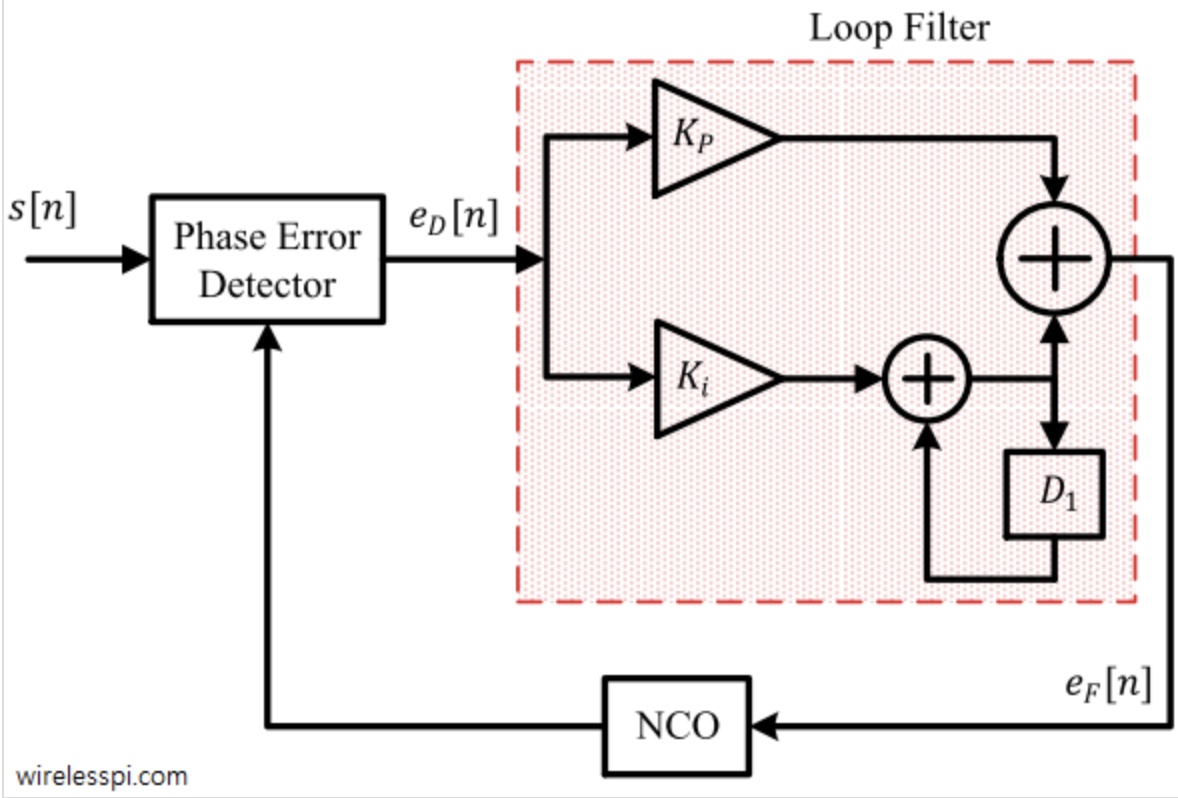
</div>

As we will see later in deriving PI filter time constants, there are two main knobs for the PI Loop filter: **damping factor** and **loop bandwidth**.

**Damping Factor ($\zeta$):** a damping factor, $\zeta$, is used to control the oscillatory behavior of the impulse response. When $\zeta < 1$, a system is _underdamped_ and can exhibit overshoots and undershoots, but fast loop convergence time. When $\zeta > 1$, a system is _overdamped_ and oscillatory behavior dissapears, however results in long convergence time. A good balance between convergence time and oscillatory behavior is $\zeta = \frac{1}{\sqrt{2}} \approx 0.707$

<div style="text-align:center;">
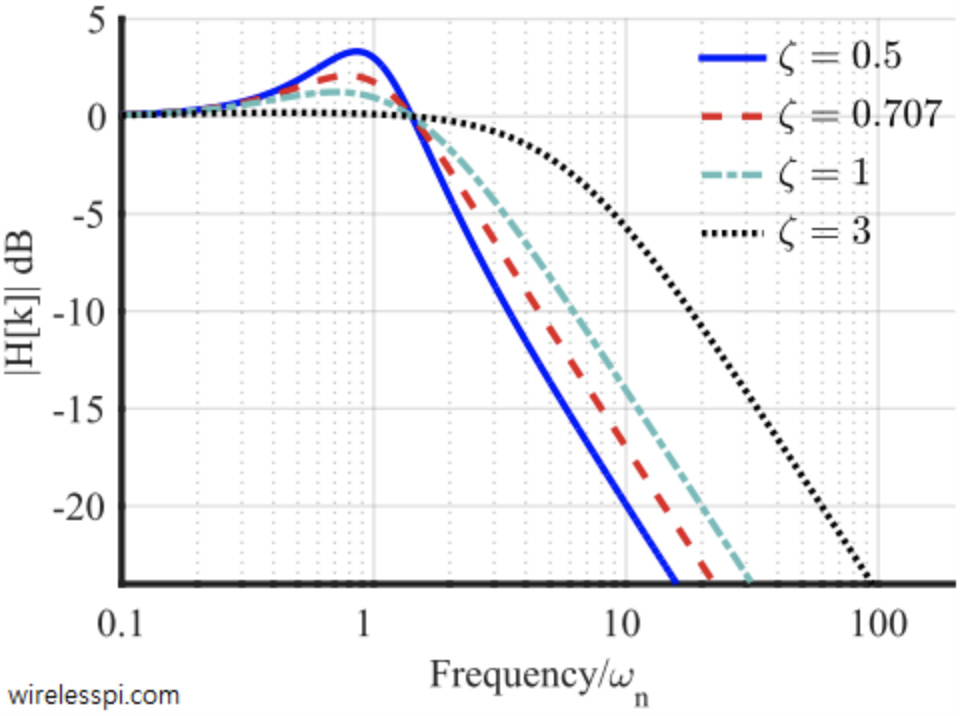
</div>

In [2]:
zeta = 1/np.sqrt(2)
print(f"Damping factor: {zeta}")

Damping factor: 0.7071067811865475


**Loop Bandwidth ($B_{n}$):** the frequency response of a PI filter is a _lowpass filter_, and therefore has a an effective bandwidth of frequencies it can respond to (e.g. DC to some 3dB point $B_{n}$). In the case of a PLL/FLL, this is the range of phase and frequency variations the loop can track and adjust to. 

Given symbol rate, $R$, the intended loop bandwidth (also known as the _Noise Bandwidth_ to refer to the range of frequencies the loop should respond to), $B_{n}$, is suggested to be between:
$$ R/20 \leq B_{n} \leq R/200 $$

A higher loop bandwidth allows faster acquisition and can track a larger range of variations, while a lower loop bandwidth can allow for low-noise tracking after acquisition. In this case, some PLL/FLLs use a different set of coefficients to lower the loop bandwidth, and attenuate more noise/variation, when a carrier has been successfully acquired and locked (tracking stage).

In [3]:
R = 15e6                   # Example symbol rate: 15 MSymbol/s
Bn = 1/100                 # Fraction of symbol rate to set loop bandwidth (here 1% of R)
w3db = 2 * np.pi * R * Bn  # Target 3dB loop bandwidth (rad/s)
print(f"PI Loop filter bandwidth: {w3db} (rad/s) [{w3db/(2*np.pi*1000)} kHz]")

PI Loop filter bandwidth: 942477.7960769379 (rad/s) [150.0 kHz]


## Loop Model

In communications systems, the PI loop filter forms a _Type 2 loop_ in order to track offsets to zero error, which means it has two poles at $z = 1$: one pole is the integrator of the PI filter, and the other is the pole formed by the phase accumulator in the NCO. Here we can model a notional Carrier Recovery (CR) loop in the $z$-domain consisting of a Phase Error Detector (PED), PI loop filter and phase compensation NCO.

### PED Model

A PED can take many forms, however here we will model a simple cross product phase detector. The product of one signal and the complex conjugate of the other gives a vector with an angle to the x-axis equivalent to the phase difference between the two signals:

<div style="text-align:center;">
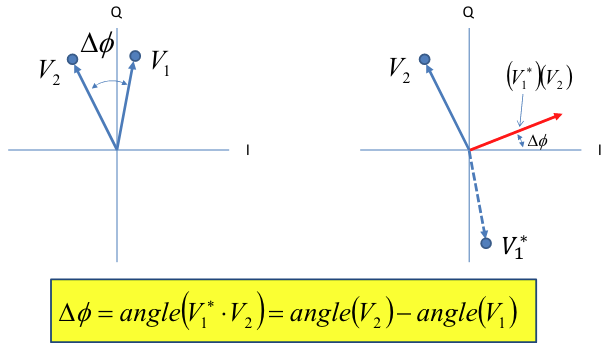
</div>

Based on a simplified (e.g. floating-point) PED, the output of this PED ranges from $ 0 \rightarrow \pi $ radians, as the exact phase difference/measurement. For practical PEDs, the output range (and associated _detector gain_, $K_{d}$) may be different (e.x. fixed-point integer math). Given the aforementioned range, we can say the detector gain (aka discriminator gain) is $K_{d} = \pi$.

In [4]:
Kd = np.pi

## PED as a cross-product phase detector:
# NOTE: cross-product detector has gain of A^2 so in FXP, to normalize error signal to
# +/- 1.0, one could adjust Kp/Ki values, or multiply error signal by: Kd = 1/(amp**2)
# However, this error signal directly gives the cross-product angle measurement in a 
# range of 0..pi radians.
#  See Dan B.'s class notes for more info on how vector product's angle == phase difference and other PEDs
def PED(y0: complex, y1: complex) -> float:
    return np.angle(np.conj(y0) * y1)

As well, we are assuming this PED has a directly linear relationship between phase error and detected output/error signal. In practical PEDs, this can also be assumed that they are approximately linear when operating within a nominal lock range (e.g. when tracking in vicinity of zero-error). However, different detectors like Decision Directed PEDs (ones that give phase error to a nearest constellation value or other symbol-aided acquisition techniques) may operate in non-linear regions and is beyond the scope of this doc. But for this model, we can assume a linear PED, yielding a transfer function of:
$$ H_{PED}(z) = K_{d} = \pi $$

<div style="text-align:center;">
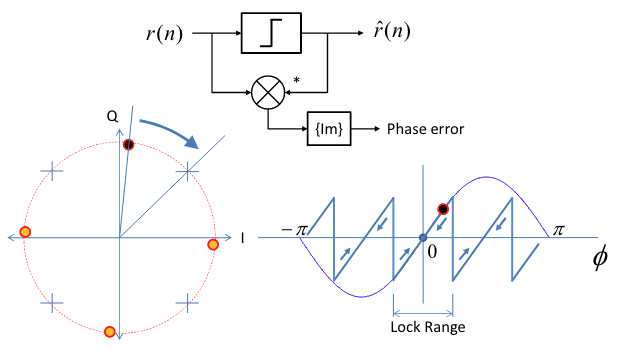
</div>

In [5]:
H_ped = Kd



### NCO Model

An NCO's basic operation is to accumulate a _Frequency Control Word_ (FCW) into a phase accumulator, and use the most-significant-bits as an index into a _look-up table_ (LUT) holding sinusoidal sample values.

<div style="text-align:center;">
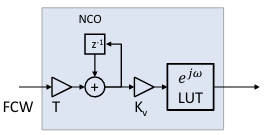
</div>

The scaling of the FCW by the symbol period, $T = 1/R$, and the associated phase accumulator gain, $K_{v}$ is convienent for modeling the loop gain with normalized error (e.g. +/- 1.0). In implementation, the NCO gain is dependent on NCO construction (e.g. phase accumulator width, LUT table size, NCO clock frequency, etc.). For simplicity in demonstrating phase to frequency conversion of the NCO, we'll model the gain as the inverse of symbol period:
$$ K_{v} = \frac{1}{T} $$

The associated transfer function of the NCO as an integrator with parasitic delay in control loop (e.g. a simple $z^{-1}$ delay stage in loop implementation) can be shown as a simple integrator with no zeros:
$$ H_{NCO}(z) = K_{v}\left(\frac{Tz}{z-1}\right)z^{-1} = \frac{1}{T}\left(\frac{T}{z-1}\right) = \boldsymbol{\frac{1}{z-1}} $$

In [6]:
T  = 1/R  # Symbol duration (seconds)
Kv = 1/T  # NCO gain
# the numerator z in NCO cancels with denominator z from parasitic delay in loop
H_nco = con.tf(Kv*T, [1, -1], T) # NCO transfer function (phase accumulator) w/o numerator z
print(H_nco)

<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


  1
-----
z - 1

dt = 6.666666666666667e-08



### PI Filter Model

As mentioned previously, the PI loop filter consists of an accumulator with an integral gain term, and a proportional gain term, summed together at the output. A second order system can be "tuned" by optimizing the closed loop pole locations ($\tau_{1}$ and $\tau_{2}$) via root locus, which gives us our gain coefficient values. However, we can also derive these poles using the Canonical Form for a 2nd order analog (e.g. continuous-time) system for starting values, which we then modify to form our discrete-time model. In this case, we need only the damping factor, $\zeta$, and the loop bandwidth, $B_{n}$, to derive the natural frequency, $\omega_{n}$, and loop/time constants ($\tau_{1}$ and $\tau_{2}$).

<div style="text-align:center;">
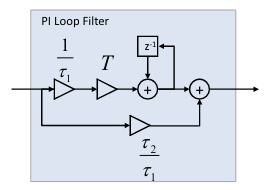
</div>

The natural frequency (rad/s) can be found from the damping factor, $\zeta$, and loop bandwidth, $B_{n}$ (in rad/s), as:
$$ \omega_{n} = \frac{B_{n}}{\sqrt{\alpha + \sqrt{\alpha^{2} + 1}}},\quad \alpha = 1 - 2\zeta^{2} $$

It can also be seen that when the damping factor $ \zeta = 1/\sqrt{2}$ that the denominator term of the natural frequency $==1$ as the $\alpha$ term goes to $0$, effectively meaning that the natural frequency is the same as the loop bandwidth.

In [7]:
alpha = 1-(2*(zeta**2))
wn = w3db/(np.sqrt(alpha+np.sqrt(alpha**2+1))) # natural frequency
print(f"Natural frequency:\t{wn} (rad/s)")
print(f"Loop bandwidth:\t\t{w3db} (rad/s)")

Natural frequency:	942477.7960769379 (rad/s)
Loop bandwidth:		942477.7960769379 (rad/s)


Now the time constants $\tau_{1}$ and $\tau_{2}$ can be calculated as:
$$ \tau_{1} = \frac{K_{v}K_{d}}{\omega_{n}^{2}},\quad \tau_{2} = \frac{2\zeta}{\omega_{n}} $$

In [8]:
tau1 = Kv*Kd/(wn**2)
tau2 = 2*zeta/wn

H_lf = con.tf([(T+tau2)/tau1, -tau2/tau1], [1, -1], T) # PI loop filter

# Show the combined, open-loop gain response as a function with two-poles and one zero
Gol = H_ped * H_nco * H_lf
print(Gol)

print(f"Tau1: {tau1}")
print(f"Tau2: {tau2}")

<TransferFunction>: sys[4]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


0.09281 z - 0.08886
-------------------
   z^2 - 2 z + 1

dt = 6.666666666666667e-08

Tau1: 5.305164769729844e-05
Tau2: 1.5005271935951767e-06


### Impulse Response & Acquisition Time
When a PI filter is used within a PLL/FLL, there is a finite amount of time for the loop to reduce the system error to zero. In communications systems, the _acquisition time_ is the sum of time to achieve both frequency and phase locks. It's inversely proportional to noise bandwidth $B_{n}$, as a higher bandiwdth allows the loop to track rapid variations at the expense of added noise.

With the closed-loop model, we can accurately derive how quickly the loop responds, and settles, to a sudden variation of frequency/phase offset by analyzing the step response:

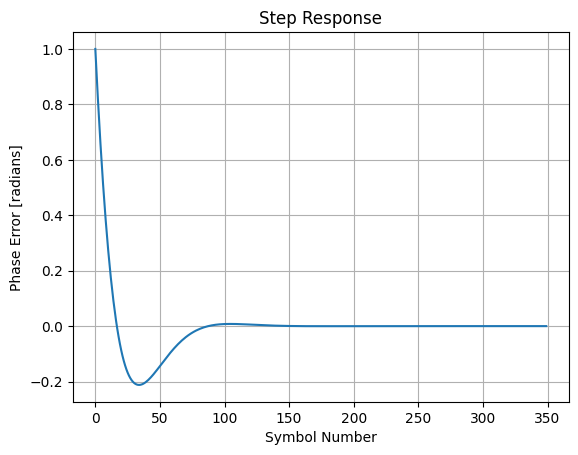

In [9]:
plt.figure()
num_step_samples = 350
t, yout = con.step_response(1/(1+Gol), T = np.arange(num_step_samples)*T)
plt.plot(t/T, yout)
plt.grid()
plt.xlabel("Symbol Number")
plt.ylabel("Phase Error [radians]")
plt.title("Step Response")
plt.show()

Another common estimation of response to first-order systems (though this is a 2nd-order loop), is the rule-of-thumb that the 3dB bandwidth is roughly $0.35 / t_{r}$, where $t_{r}$ is the 10/90% rise/fall time of an impulse edge (this rule-of-thumb is seen a lot in PCB HW design). While not exceedingly accurate, this same rule can be used here to estimate how many symbols the loop takes to compensate for a sudden (e.g. impulse) offset in phase and/or frequency, given the symbol/update rate, $R$, and 3dB PI loop bandwidth, $B_{n}$:

$$ N_{symbols} \approx \frac{0.35R}{B_{n}} $$

In [10]:
print(f"Loop estimate to respond to impulse: {R * 0.35 / (w3db/(2*np.pi))} symbols")

Loop estimate to respond to impulse: 35.0 symbols


We can also show the location of poles (again, at the origin given the two poles at $z=1$ from the PI filter and NCO) and zeros of the system:

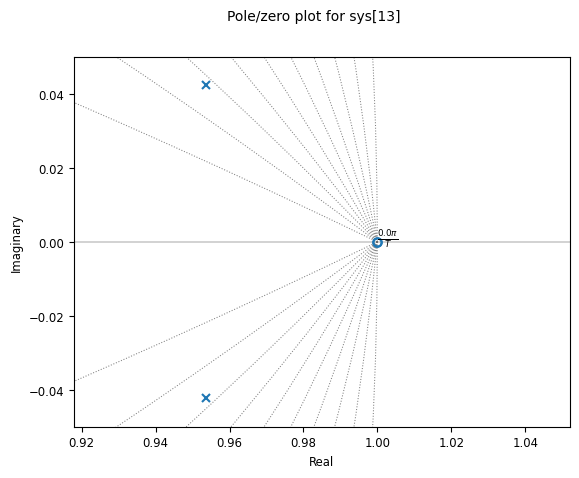

In [11]:
plt.figure()
con.pzmap(1/(1+Gol), grid = True)
plt.axis([0.95, 1.02, -0.05, 0.05]);
plt.show()

From here, we can finally calculate the discrete-time, PI loop filter gain constants.

**Proportional Gain Constant ($K_{p}$):** scalar value directly multiplied to input error value. Therefore it direclty adjusts the amount the current input error contributes to system output response (e.g higher $K_{p}$ means a larger change in output for a given change in input error). This proportional term also provides stability control (e.g. phase margin) of the loop:
$$ K_{p} = \frac{\tau_{2}}{\tau_{1}} $$

In [12]:
Kp = tau2/tau1
print(f"Kp: {Kp}")

Kp: 0.0282842712474619


**Integral Gain Constant ($K_{i}$):** scalar value directly multiplied to the integrated error value. The integral term is simply an accumulator of error values over time and gives the accumulated offset that should have been corrected previously. This term moves the system output towards a steady-state, setpoint:
$$ K_{i} = \frac{T}{\tau_{1}} $$

In [13]:
Ki = T/tau1
print(f"Ki: {Ki}")

Ki: 0.0012566370614359175


#### $K_{i}$ & $K_{p}$ using Normalized Loop Bandwidth

When a synchronous (every thing runs at same clock/sample rate) 2nd order PI loop is used, and the 2nd pole ($z = 1$) stage which uses the output of the PI filter (e.x. an NCO in PLL/FLL), the $K_{v}$ term which scales by sample frequency can be eliminated. In this case, $K_{i}$ and $K_{p}$ derivation can be drastically simplified and only depend on damping factor, $\zeta$, and normalized, fractional (e.g. $0 \rightarrow 2\pi$) loop bandwidth $\omega_{frac}$.

Given previous equations:
$$ T = 1 / \omega_{f_{s}},\quad K_{v} = 1/T \rightarrow K_{v} = \omega_{f_{s}} $$
$$ \omega_{n} = \omega_{f_{s}} * \omega_{frac} $$
$$ \tau_{1} = \frac{K_{v}K_{d}}{\omega_{n}^{2}},\quad \tau_{2} = \frac{2\zeta}{\omega_{n}} $$
$$ K_{p} = \frac{\tau_{2}}{\tau_{1}},\quad K_{i} = \frac{T}{\tau_{1}} $$

**NOTE:** sample/symbol frequency $\omega_{f_{s}}$ assumed pre-scaled by $\alpha$ equation to find natural frequency $\omega_{n}$, and in cases where damping factor $\zeta = 1/\sqrt{2}$, the sample/symbol and natural frequencies are equivalent. Since $\omega_{f_{s}}$ cancels out, we can still scale $\omega_{frac}$ by that $\alpha$ factor equation for other damping factors, thus assume:
$$ \omega_{frac} \equiv \frac{\omega_{frac}}{\sqrt{\alpha + \sqrt{\alpha^{2} + 1}}},\quad \alpha = 1 - 2\zeta^{2} $$

**NOTE:** that the $\omega_{frac}$ is normalized to radians around a unit circle ($0 \rightarrow 2\pi$), so if the fractional bandwidth is given as a percentage of total bandwidth (e.g. sample/symbol frequency), it should be multiplied by $2\pi$ before use in these simplified equations.

Plug-in constants:
$$ K_{p} = \frac{\frac{2\zeta}{\omega_{f_{s}}\omega_{frac}}}{\frac{\omega_{f_{s}}K_{d}}{(\omega_{f_{s}}\omega_{frac})^{2}}} \rightarrow K_{p} = \frac{\frac{2\zeta}{\omega_{f_{s}}\omega_{frac}}}{\frac{K_{d}}{\omega_{f_{s}}\omega_{frac}^{2}}} \rightarrow K_{p} = \frac{2\zeta}{\cancel{\omega_{f_{s}}\omega_{frac}}} * \frac{\cancel{\omega_{f_{s}}}\omega_{frac}^{\cancel{2}}}{K_{d}} \rightarrow  \boldsymbol{ K_{p} =  \frac{2\zeta\omega_{frac}}{K_{d}} } $$

$$ K_{i} = \frac{\frac{1}{\omega_{f_{s}}}} {\frac{\omega_{f_{s}} K_{d}}{(\omega_{f_{s}} \omega_{frac})^{2}}} \rightarrow  K_{i} = \frac{\frac{1}{\omega_{f_{s}}}} {\frac{K_{d}}{\omega_{f_{s}} \omega_{frac}^{2}}} \rightarrow  K_{i} = \frac{1}{\cancel{\omega_{f_{s}}}} * \frac{\cancel{\omega_{f_{s}}} \omega_{frac}^{2}}{K_{d}} \rightarrow  \boldsymbol{ K_{i} = \frac{\omega_{frac}^{2}} {K_{d}} } $$

In [14]:
w_frac = 2 * np.pi * Bn
Kp_new = 2 * zeta * w_frac / Kd
Ki_new = w_frac * w_frac / Kd
print(f"Kp: {Kp_new}")
print(f"Ki: {Ki_new}")
assert(Kp_new == Kp)
assert(Ki_new == Ki)

test_pi_filt = pi_filter.PiFilter(Bn, Kd)
assert(Kp_new == test_pi_filt.Kp)
assert(Ki_new == test_pi_filt.Ki)

Kp: 0.0282842712474619
Ki: 0.0012566370614359175


## PI Loop Filter Simulation in Carrier Recovery (CR) Loop

<div style="text-align:center;">
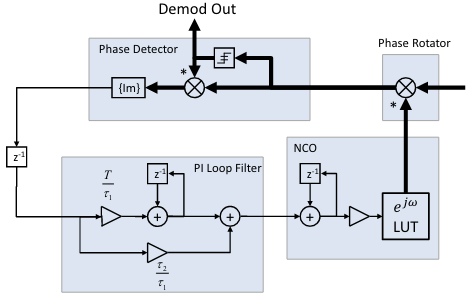
</div>

To put the math and models together, we can fully simulate a Carrier Recovery (CR) loop which consists of a cross-product PED, PI filter and compensation NCO. The loop assumes timing has been recovered (e.g. post-TED) and is running at 1x sample/symbol. The loop starts with a 180 degree phase offset, and a -2kHz frequency offset, and is shown to rapidly converge to a locked state.

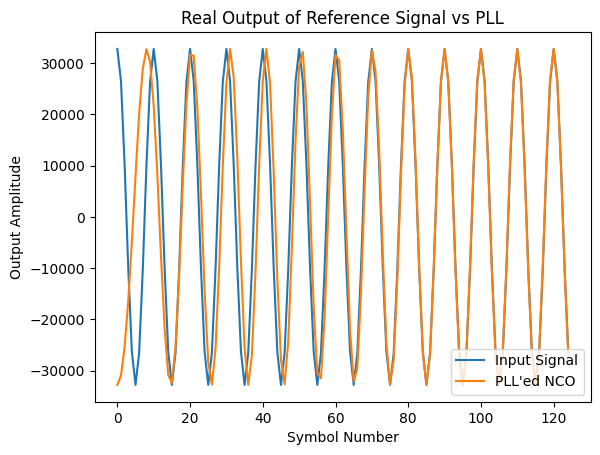

In [15]:
## Define NCO constants & create reference + PLL NCOs
P  = 9   # LUT table address length (total depth = 2^P)
M  = 16  # quantized word length (num bits)
N  = 24  # phase accumulator length (num bits)
n  = num_step_samples  # number of output points to compute
fs = 10*R  # NCO sampling frequency (10x oversampled for cleaner sine wave output)

ref_NCO = nco.Nco(N, M, P, fs, init_phase=0)         # Initialize reference signal NCO phase accumulator -> 0
pll_NCO = nco.Nco(N, M, P, fs, init_phase=2**(N-1))  # Initialize PLL NCO phase accumulator -> 180deg phase offset from reference

# FCW (increment for NCO phase accumulator) for reference NCO output frequency in this 
# sim is a sine wave @ symbol rate (1x sample/symbol)
ref_NCO.SetOutputFreq(R)

## Initialize output sample, PED & PI integrator vectors (statically sized)
y0    = np.zeros(n) + 1j*np.zeros(n)
y_nco = np.zeros(n) + 1j*np.zeros(n)
err   = np.zeros(n)
ped_output = np.zeros(n)

# Create PI Filter:
#  Scale normalized (e.g. +/- 1.0) Ki & Kp coefficients by /2 of NCO FCW width (+/- 2^N-1)
#  NOTE: not needed in sims where FCW of NCO/phasor output is also normalized (e.g. +/- 0.5)
pi_filt = pi_filter.PiFilter(Bn, Kd, (2 ** (N-1)))

# NCO in PLL starts with a -2kHz frequency offset, which in this case means an initial value in the PI 
# loop filter's accumulator (e.g. integrator section), since the PI filter output _is_ the
# FCW input to the NCO
pi_filt.accumulator = nco.FreqToFcw(R - 2000, N, fs)
pll_NCO.FCW = pi_filt.accumulator  # this will be set each cycle in the loop as well


## Simulate a synchronous CR loop
for i in range (n):
    # Reference signal NCO accumulates w/o influence
    y0[i] = ref_NCO.Step()
    
    # Output current cycle's PLL NCO based on last cycle's, previous phase accumulator value
    y_nco[i] = pll_NCO.GetCurrentNcoOutput()
    
    err[i] = PED(y_nco[i], y0[i])
    
    ## PI filter implementation based on PED output/error value
    ped_output[i] = pi_filt.Step(err[i])
   
    # Update PLL NCO's FCW and phase accumulator value based on PI filter output
    # NOTE: this is done separately than the simple NCO.step() function to model
    #       the timing behavior of a digital NCO with input PI filter, though this
    #       will still converge to zero-error (or, the impulse response can be
    #       modified to represent the open-loop transfer function with extra delays
    #       representing pipeline stages)
    pll_NCO.IncPhaseAcc(ped_output[i])

        
num_start_samples = 125
plt.figure()
plt.plot(y0.real[:num_start_samples], label="Input Signal")
plt.plot(y_nco.real[:num_start_samples], label="PLL'ed NCO")
plt.legend(loc='lower right')
plt.title("Real Output of Reference Signal vs PLL")
plt.ylabel("Output Amplitude")
plt.xlabel("Symbol Number")
plt.show()

It can be seen in the time-domain that the loop rapidly converges to lock the PLL's NCO to the input carrier. We can also show that the discrete PLL response matches _exactly_ to the $z$-domain impulse response shown earlier:

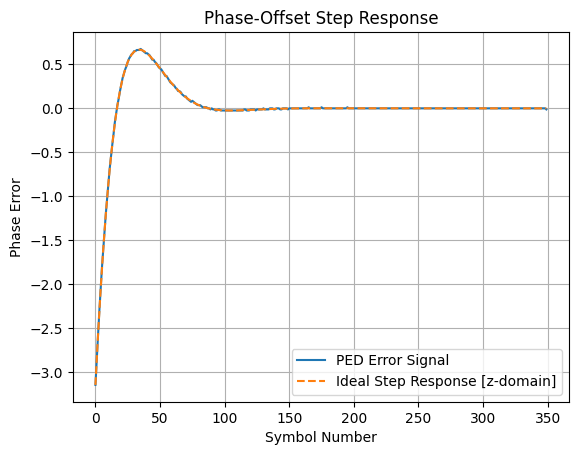

In [16]:
plt.figure()
plt.plot(err, label="PED Error Signal")
# scale the normalized step response (+/- 1.0) by the maximum simulated error magnitude from PED
# NOTE: the maximum PED value should be ~3.141 (pi) as max radian offset between signals
ped_max = max(abs(err))
plt.plot(t/T, -ped_max*yout, '--', label="Ideal Step Response [z-domain]")
plt.grid()
plt.xlabel("Symbol Number")
plt.ylabel("Phase Error")
plt.title("Phase-Offset Step Response")
plt.legend(loc='lower right')
plt.show()

As well, the PI filter's output can be normalized to the NCO's frequency control word to show the associated frequency track to compensate for phase and frequency offsets. It also shows that the output settles to exactly the input carrier's frequency (15 MHz):

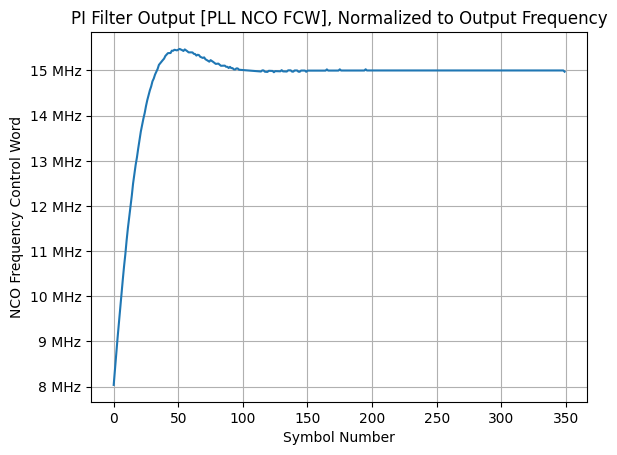

In [17]:
plt.figure()
plt.plot(nco.FcwToFreq(ped_output, N, fs))
plt.grid()
plt.xlabel("Symbol Number")
plt.ylabel("NCO Frequency Control Word")
plt.title("PI Filter Output [PLL NCO FCW], Normalized to Output Frequency")
ax = plt.gca()
ax.yaxis.set_major_formatter(EngFormatter(unit="Hz"))
plt.show()

## References

* _DSP for Software Radio_, Dan Boschen, Class 4
* [Phase Locked Loop (PLL) in a Software Defined Radio (SDR) - Wireless Pi](https://wirelesspi.com/phase-locked-loop-pll-in-a-software-defined-radio-sdr/)
  - Screenshot pictures from this article
* [How a Frequency Locked Loop (FLL) Works](https://wirelesspi.com/how-a-frequency-locked-loop-fll-works/)
* [Digital PLL's - Part 1, DSPRelated.com](https://www.dsprelated.com/showarticle/967.php)
* [Digital PLL's - Part 2, DSPRelated.com](https://www.dsprelated.com/showarticle/973.php)
* [PID Controller - Wikipedia](https://en.wikipedia.org/wiki/PID_controller)
* [MATLAB Communications Toolbox - Algorithms](https://www.mathworks.com/help/comm/ref/comm.carriersynchronizer-system-object.html#bultrxw-19)